In [1]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon

from Functions import pivot_data_by_HSA, merge_and_rename_data, add_changes_by_week, create_column_names, create_collated_weekly_data,prep_training_test_data_period, cross_validation_leave_geo_out, calculate_metrics, add_labels_to_subplots
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']

In [2]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

# Polygons for mapping onto waves

In [3]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_22868/4200828156.py:4: DtypeWarning: Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')


# Percent exceeding capacity 

In [11]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)

# Parameters for functions

In [156]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [5]:
working_directory = "/Users/rem76/Documents/COVID_projections/Expanding_models_period_sensitivity_time_period/"

# Full model

In [165]:

ROC_thresholds = {}
accuracy_thresholds = {}
MCC_thresholds = {}
size_of_test_dataset = 1

outcome_periods = [2,4,6]

for outcome_period in outcome_periods:
    weeks_in_future = outcome_period
    ROC_list = f"ROC_by_week_full_period_{outcome_period}"
    accuracy_list = f"accuracy_by_week_full_period_{outcome_period}"
    MCC_list = f"MCC_by_week_full_period_{outcome_period}"

    ROC_thresholds[ROC_list] = []
    accuracy_thresholds[accuracy_list] = []
    MCC_thresholds[MCC_list] = []
    
    for prediction_week in weeks_to_predict:
            model_name_to_load = working_directory + "Full_model_" + time_period + "_" + str(prediction_week) + "_" + str(outcome_period) + "_weeks"  + ".sav"
            clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

            print(prediction_week)

            #period    

            X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)

            X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
            weights_full = weights_full[0].to_numpy()
            clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

            # Make predictions on the test set
            y_pred = clf_full_period.predict(X_test_full)
            y_pred_proba = clf_full_period.predict_proba(X_test_full)
            accuracy_thresholds[accuracy_list].append(accuracy_score(y_test_full, y_pred))
            MCC_thresholds[MCC_list].append((matthews_corrcoef(y_test_full, y_pred) + 1)/2)
            if (y_test_full.sum()/len(y_test_full)).item() < 1:
                ROC_thresholds[ROC_list].append(roc_auc_score(y_test_full, y_pred_proba[:, 1]))
            else:
                ROC_thresholds[ROC_list].append(np.nan)
                print('all')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
all
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


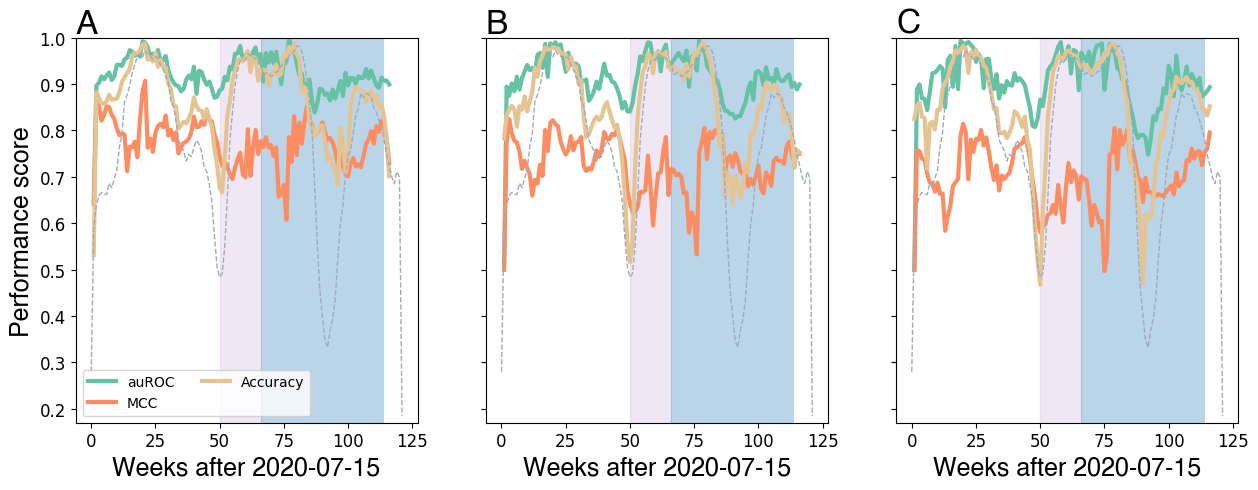

In [18]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey = 'all')

for i, ax in enumerate(axs):

    roc_values = list(ROC_thresholds.values())[i]
    mcc_values = list(MCC_thresholds.values())[i]
    accuracy_values = list(accuracy_thresholds.values())[i]

    ax.plot(weeks_to_predict[0:len(roc_values)], roc_values, label='auROC', linewidth=3, color=palette[0])
    ax.plot(weeks_to_predict[0:len(roc_values)], mcc_values, label='MCC', linewidth=3, color=palette[1])
    ax.plot(weeks_to_predict[0:len(roc_values)], accuracy_values, label='Accuracy', linewidth=3, color=palette[5])
    ax.plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

    ax.set_xlabel('Weeks after 2020-07-15', **hfont, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylim(0.17,1)


    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')
plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_full_expanding_train_models_period__{size_of_test_dataset}_week_outcome_period.png', dpi = 300)

# Naive classifier threhsold analysis

In [159]:

ROC_outcome_period_naive = {}
accuracy_outcome_period_naive = {}
MCC_outcome_period_naive = {}
size_of_test_dataset = 1

outcome_periods = [2,4, 6]

for outcome_period in outcome_periods:
    weeks_in_future = outcome_period
    ROC_list = f"ROC_by_week_naive_period_{outcome_period}"
    accuracy_list = f"accuracy_by_week_naive_period_{outcome_period}"
    MCC_list = f"MCC_by_week_naive_period_{outcome_period}"

    ROC_outcome_period_naive[ROC_list] = []
    accuracy_outcome_period_naive[accuracy_list] = []
    MCC_outcome_period_naive[MCC_list] = []

    for prediction_week in weeks_to_predict:

        print(prediction_week)
        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)

        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
        weights_naive = weights_naive[0].to_numpy()
        clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model
        accuracy_outcome_period_naive[accuracy_list].append(accuracy_score(y_test_naive, y_pred))
        if (y_test_naive.sum()/len(y_test_naive)).item() < 1:
            ROC_outcome_period_naive[ROC_list].append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
        else:
            ROC_outcome_period_naive[ROC_list].append(np.nan)
            print('all')
        MCC_outcome_period_naive[MCC_list].append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
all
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


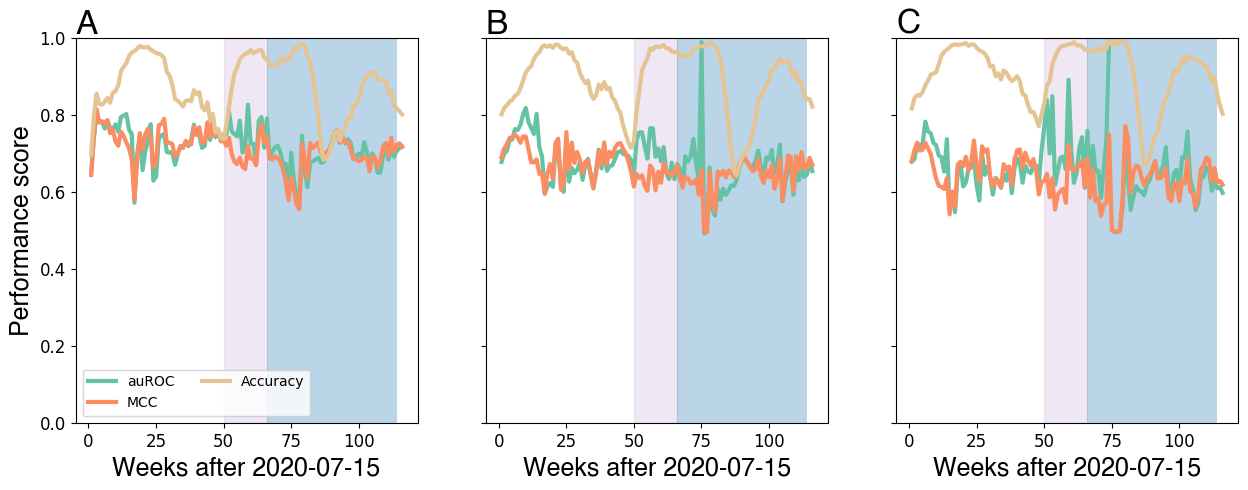

In [98]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey = 'all')
axs = axs.ravel()
for i, ax in enumerate(axs):
    roc_values = list(ROC_outcome_period_naive.values())[i]
    mcc_values = list(MCC_outcome_period_naive.values())[i]
    accuracy_values = list(accuracy_outcome_period_naive.values())[i]

    ax.plot(weeks_to_predict, roc_values, label='auROC', linewidth=3, color=palette[0])
    ax.plot(weeks_to_predict, mcc_values, label='MCC', linewidth=3, color=palette[1])
    ax.plot(weeks_to_predict, accuracy_values, label='Accuracy', linewidth=3, color=palette[5])
    ax.set_xlabel('Weeks after 2020-07-15', **hfont, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylim(0,1)


    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 1), (last_week_delta, 1), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 1), (last_week_omricon, 1), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_naive_expanding_train_models_period__{size_of_test_dataset}_week_outcome_period.png', dpi = 300)

# Combined graph 

ValueError: x and y must have same first dimension, but have shapes (117,) and (0,)

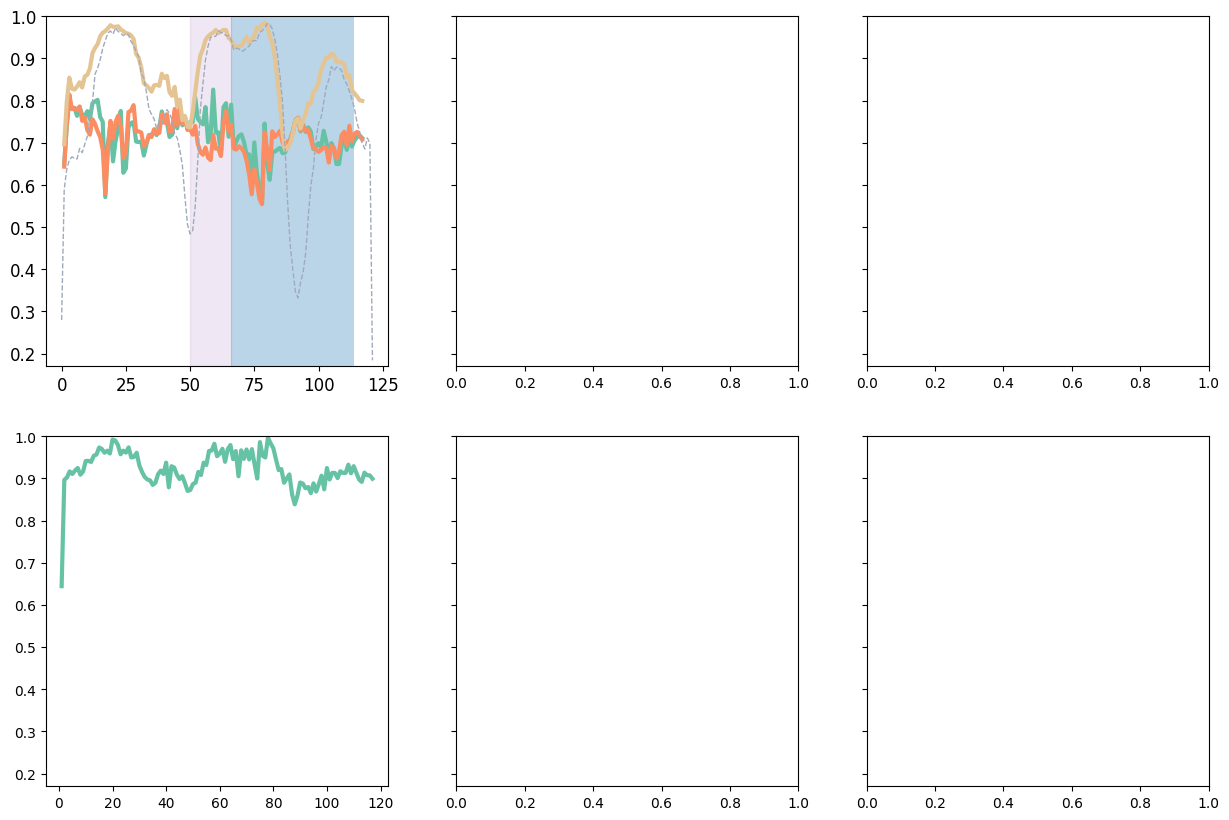

In [164]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharey='all')
axs = axs.ravel()

for i in range(3):
    # Plot data for the first set of values (naive)
    roc_values_naive = list(ROC_outcome_period_naive.values())[i]
    mcc_values_naive = list(MCC_outcome_period_naive.values())[i]
    accuracy_values_naive = list(accuracy_outcome_period_naive.values())[i]

    axs[i].plot(weeks_to_predict, roc_values_naive, label='auROC', linewidth=3, color=palette[0])
    axs[i].plot(weeks_to_predict, mcc_values_naive, label='MCC', linewidth=3, color=palette[1])
    axs[i].plot(weeks_to_predict, accuracy_values_naive, label='Accuracy ', linewidth=3, color=palette[5])
    axs[i].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, label='Prop. HSAs exceeding threshold', linewidth = 1, color = '#A0AABA', linestyle = '--')

    axs[i].tick_params(axis='both', which='major', labelsize=12)

    axs[i].set_ylim(0.17, 1)

    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 1), (last_week_delta, 1), (last_week_delta, 0)],
                            alpha=0.3, color='#cdb4db')
    axs[i].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 1), (last_week_omricon, 1),
                               (last_week_omricon, 0)], alpha=0.3)
    axs[i].add_patch(polygon_omricon)

    # Plot data for the second set of values
    roc_values = list(ROC_thresholds.values())[i]
    mcc_values = list(MCC_thresholds.values())[i ]
    accuracy_values = list(accuracy_thresholds.values())[i]

    axs[i + 3].plot(weeks_to_predict, roc_values, label='auROC', linewidth=3, color=palette[0])
    axs[i + 3].plot(weeks_to_predict, mcc_values, label='MCC', linewidth=3, color=palette[1])
    axs[i + 3].plot(weeks_to_predict, accuracy_values, label='Accuracy', linewidth=3, color=palette[5])
    axs[i + 3].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, label='Prop. HSAs exceeding threshold', linewidth = 1, color = '#A0AABA', linestyle = '--')
    axs[i + 3].set_ylim(0.17, 1)

    axs[i + 3].set_xlabel('Weeks after 2020-07-15', fontsize=18)
    axs[i + 3].tick_params(axis='both', which='major', labelsize=12)


    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 1), (last_week_delta, 1), (last_week_delta, 0)],
                            alpha=0.3, color='#cdb4db')
    axs[i+3].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 1), (last_week_omricon, 1),
                               (last_week_omricon, 0)], alpha=0.3)
    axs[i+3].add_patch(polygon_omricon)

axs[0].set_ylabel('Performance score', fontsize=18)
axs[3].set_ylabel('Performance score', fontsize=18)

axs[0].legend(ncol=2, loc='lower left')

# Add labels to subplots
add_labels_to_subplots(axs, hfont, 1.01, 24)

plt.tight_layout()
plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_naive_and_full_expanding_train_models_period__{size_of_test_dataset}_week_outcome_period.png', dpi = 300)

# Maximum regret 

In [49]:
def calculate_maximum_reget(metric, metrics_by_model, models, time_period, weeks_to_predict):
    maximum_regret_by_model = {model: [] for model in models}
    metrics_by_model = metrics_by_model.get(metric)
    for prediction_week in weeks_to_predict:
        print(prediction_week)
        best_metric = float('-inf') 
        integers_names = [w2n.word_to_num(model.split('_')[0]) if '_week' in model else 0 for model in models] ## if e.g. expanding model can go to very end

        for i, m in enumerate(metrics_by_model): 
            if (integers_names[i] <= prediction_week): # & (abs(max(weeks_to_predict) -  integers_names[i]) >= prediction_week):
                model_metric = m[prediction_week]
            else:
                model_metric = 0
            if model_metric >= best_metric:
                        best_metric = model_metric

        
        for i, m  in enumerate(metrics_by_model): 
            model = models[i]
            if (integers_names[i] <= prediction_week): # & (abs(max(weeks_to_predict) -  integers_names[i]) >= prediction_week):
                model_metric = m[prediction_week]

                if model_metric >= best_metric:
                    maximum_regret_by_model[model].append(0)
                else:
                    maximum_regret_by_model[model].append(best_metric - model_metric)   
            else:  
                maximum_regret_by_model[model].append(best_metric)    
    return maximum_regret_by_model

In [38]:
weeks_to_predict = range(1, 121 - size_of_test_dataset - 3 - train_weeks_for_initial_model)


range(1, 116)

In [39]:
weeks_to_predict = range(1, 121 - size_of_test_dataset - 3 - train_weeks_for_initial_model)
models = ['2', '4', '6', 'naive_2', 'naive_4', 'naive_6'] 
metrics_all = {}
metrics_all['ROC'] = model_metrics_ROC

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


In [52]:
maximum_regret_by_model_ROC =calculate_maximum_reget('ROC', metrics_all, models, time_period, weeks_to_predict)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


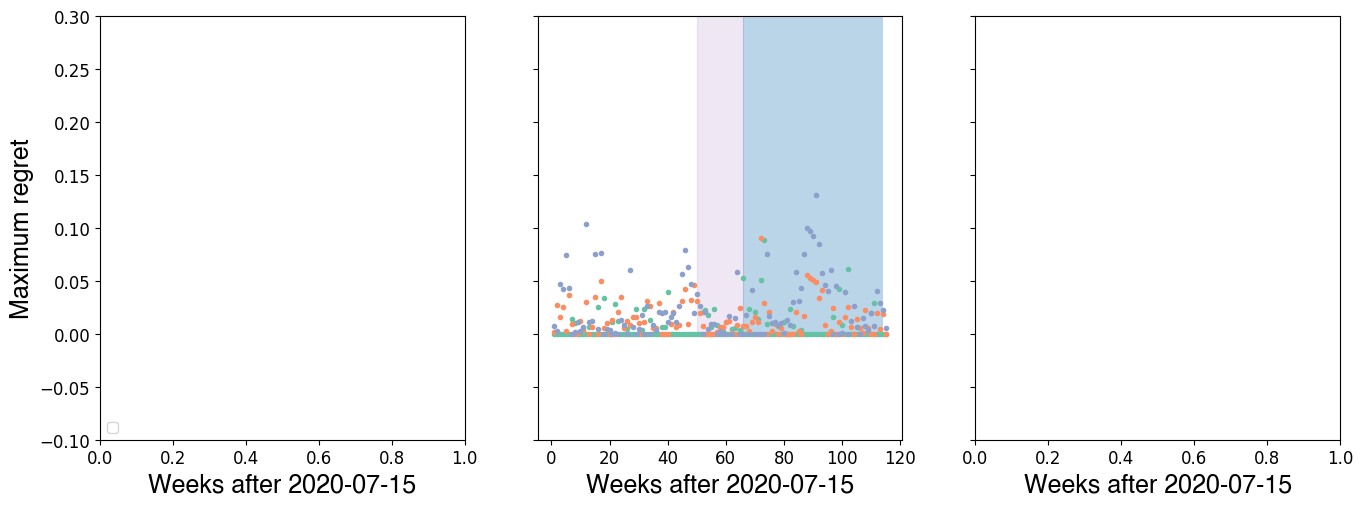

In [54]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5.5), sharey = 'all')
#for i, model in enumerate(models):
#    axs[0].plot(weeks_to_predict, maximum_regret_by_model_MCC[model], label=model, marker = '.', linestyle = '', color = palette[i])
#axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

for i, model in enumerate(models):
    axs[1].plot(weeks_to_predict, maximum_regret_by_model_ROC[model], label=model, marker = '.', linestyle = '', color = palette[i])
#axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')


# Add labels and legend
for i in range(len(axs)):
    axs[i].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    axs[i].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                        alpha=0.3)
    axs[i].add_patch(polygon_omricon)

axs[0].set_ylabel('Maximum regret',**hfont,  fontsize = 18)
axs[0].set_ylim(-.1,.3)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')
